In [2]:

#from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import os
from PIL import Image

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16, InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.legacy import Adam
from keras.metrics import AUC

In [3]:
df_helper = pd.read_csv('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-256-helper.csv')

df_helper

,patient_id,image_id,laterality,view,age,implant,path,cancer
0,10006,462822612,0,1,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
1,10006,1459541791,0,5,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
2,10006,1864590858,1,5,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
3,10006,1874946579,1,1,61.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
4,10011,220375232,0,1,55.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
...,...,...,...,...,...,...,...,...
54701,9973,1729524723,1,5,43.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54702,9989,63473691,0,5,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54703,9989,1078943060,0,1,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0
54704,9989,398038886,1,5,60.0,0,/kaggle/input/rsna-breast-cancer-detection/tra...,0


In [4]:
# Load the directory containing the images
image_directory = '/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-516/'

# Initialize lists to store data
image_sizes = []
image_paths = []

# Iterate over each image in the directory
for image_name in os.listdir(image_directory):
    if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tif', '.tiff')):
        image_path = os.path.join(image_directory, image_name)
        image = Image.open(image_path)
        image_sizes.append(image.size)  # Store image size (width, height)
        image_paths.append(image_path)

# Convert to numpy array for analysis
image_sizes = np.array(image_sizes)

In [5]:
# Construct the image_path column dynamically
df_helper['image_path'] = '/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/RSNA-516/' + df_helper['patient_id'].astype(str) + '_' + df_helper['image_id'].astype(str) + '.png'

#Select columns need for analysis
df = df_helper[['image_path', 'cancer']]
print(df_helper['cancer'].value_counts())

cancer
0    53548
1     1158
Name: count, dtype: int64


<Axes: ylabel='count'>

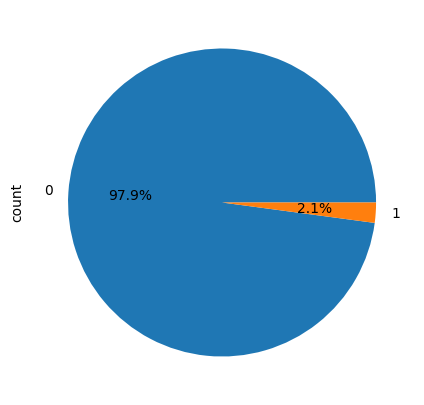

In [6]:
df_helper['cancer'].value_counts().plot.pie(autopct='%.1f%%', figsize=(5, 5))

cancer
1    1158
0    1158
Name: count, dtype: int64


<Axes: ylabel='count'>

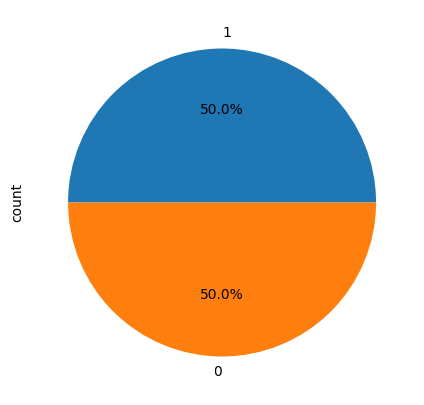

In [7]:
# Get the number of instances with class 1 (cancer)
num_cancer = df['cancer'].value_counts()[1]

# Get the indices of instances with class 1 (cancer)
indexs_cancer = np.array(df[df['cancer'] == 1].index)

# Get the indices of instances with class 0 (not cancer)
indexs_not_cancer = np.array(df[df['cancer'] == 0].index)

# Get indices of instances with class 0 (not cancer) randomly sampled with the same amount as class 1 (cancer)
indexs_not_cancer_balanced = np.random.choice(indexs_not_cancer, num_cancer, replace=False)

# Concatenate indices of instances with class 0 and 1
indexs_balanced = np.concatenate([indexs_cancer, indexs_not_cancer_balanced])

# Create a new dataframe with balanced classes
df_balanced = df.iloc[indexs_balanced, :]

# Check the class distribution after balancing
print(df_balanced['cancer'].value_counts())

# Plot pie chart to visualize the balanced class distribution
df_balanced['cancer'].value_counts().plot.pie(autopct='%.1f%%', figsize=(5, 5))

In [8]:
from matplotlib.image import imread

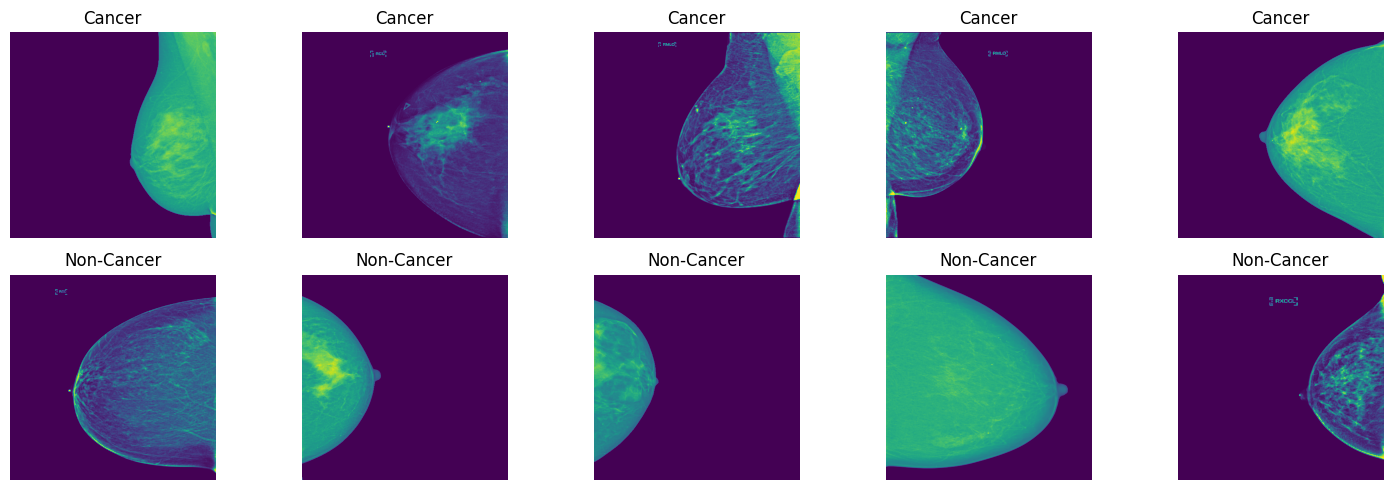

In [9]:
# Filter images based on cancer_label
cancer_images = df_balanced[df_balanced['cancer'] == 1].sample(5)  # Select 5 cancer images randomly
non_cancer_images = df_balanced[df_balanced['cancer'] == 0].sample(5)  # Select 5 non-cancer images randomly

# Plotting cancer images
plt.figure(figsize=(15, 5))
for i, (index, row) in enumerate(cancer_images.iterrows()):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imread(row['image_path']))
    plt.title('Cancer')
    plt.axis('off')

# Plotting non-cancer images
for i, (index, row) in enumerate(non_cancer_images.iterrows()):
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(imread(row['image_path']))
    plt.title('Non-Cancer')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
X_train, X_val_test, y_train, y_val_test = train_test_split(df_balanced['image_path'], df_balanced['cancer'], test_size=0.4, random_state=42, stratify = df_balanced['cancer'])
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42, stratify=y_val_test)


In [11]:
# Create DataFrames for train, validation, and test sets
train_df = pd.DataFrame({'image_path': X_train, 'cancer': y_train})
val_df = pd.DataFrame({'image_path': X_val, 'cancer': y_val})
test_df = pd.DataFrame({'image_path': X_test, 'cancer': y_test})

# Check class distribution in each set
train_class_distribution = train_df['cancer'].value_counts(normalize=True)
val_class_distribution = val_df['cancer'].value_counts(normalize=True)
test_class_distribution = test_df['cancer'].value_counts(normalize=True)

print("Train Set Class Distribution:")
print(train_class_distribution)
print("\nValidation Set Class Distribution:")
print(val_class_distribution)
print("\nTest Set Class Distribution:")
print(test_class_distribution)

Train Set Class Distribution:
cancer
1    0.50036
0    0.49964
Name: proportion, dtype: float64

Validation Set Class Distribution:
cancer
0    0.50108
1    0.49892
Name: proportion, dtype: float64

Test Set Class Distribution:
cancer
1    0.5
0    0.5
Name: proportion, dtype: float64


In [12]:
# ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    #zoom_range=0.4, # Randomly rotate images by up to 40 degrees
    brightness_range = [0.8,1.2], # Randomly adjust brightness between 0.8 and 1.2
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Parameters
batch_size = 32
target_size = (299, 299)  # InceptionNetV3 input size

In [13]:
# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_train, 'cancer': y_train.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_val, 'cancer': y_val.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_path': X_test, 'cancer': y_test.astype(str)}),
    x_col='image_path',
    y_col='cancer',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 1389 validated image filenames belonging to 2 classes.
Found 463 validated image filenames belonging to 2 classes.


Found 464 validated image filenames belonging to 2 classes.


In [14]:
# Extract the inputs and labels from the generator
inputs = []
labels = []
for i in range(len(test_generator)):
    batch_inputs, batch_labels = test_generator[i]
    inputs.append(batch_inputs)
    labels.append(batch_labels)

# Concatenate the batches to form the complete dataset
inputs = np.concatenate(inputs, axis=0)
labels = np.concatenate(labels, axis=0)

# Save the inputs and labels to numpy files
np.save('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/test_inputs.npy', inputs)
np.save('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/test_labels.npy', labels)

# Plot Learning Curve Function

In [15]:
def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
      plt.figure()
      plt.plot(history.history[tgt], label=tgt)
      plt.plot(history.history[val_tgt], label=val_tgt)
      plt.xlabel('Epoch')
      #plt.ylabel(ylab)
      plt.legend()
      plt.title(f"Training and validation {tgt}")

# InceptionNetV3

In [16]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# Initial learning rate
initial_learning_rate = 0.1

In [17]:
def create_model(learning_rate):
    inceptionv3_base = InceptionV3(weights='imagenet', include_top=False)

    for layer in inceptionv3_base.layers[:-10]:
        layer.trainable = False

    x3 = inceptionv3_base.output
    x3 = GlobalAveragePooling2D()(x3)
    x3 = Dense(256, activation='relu')(x3)
    x3 = Dropout(0.5)(x3)
    predictions = Dense(1, activation='sigmoid')(x3)

    model = Model(inputs=inceptionv3_base.input, outputs=predictions)

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', AUC()])

    return model

In [18]:
# Define hyperparameters
learning_rates = [0.001,0.01]
batch_sizes = [32,64]
epochs = 10
# Define lists to store models and histories
models_list = []
histories_list = []
hyperparameter_list = []

In [19]:
for lr in learning_rates:
    for batch_size in batch_sizes:
        print(f"Training model with learning rate: {lr} and batch size: {batch_size}")
        model = create_model(lr)
        history = model.fit(train_generator, validation_data=val_generator, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

        models_list.append(model)
        histories_list.append(history)

        # Store hyperparameters for each model
        hyperparameters = {'learning_rate': lr, 'batch_size': batch_size}
        hyperparameter_list.append(hyperparameters)



Training model with learning rate: 0.001 and batch size: 32


2024-05-02 09:28:57.110907: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-05-02 09:28:57.110935: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-02 09:28:57.110941: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-02 09:28:57.110980: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-02 09:28:57.111001: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2024-05-02 09:29:00.008568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


44/44 [==============================] - 18s 373ms/step - loss: 1.4136 - accuracy: 0.5119 - auc: 0.5169 - val_loss: 0.7213 - val_accuracy: 0.5659 - val_auc: 0.5906
Epoch 2/10
44/44 [==============================] - 14s 324ms/step - loss: 0.8534 - accuracy: 0.5356 - auc: 0.5497 - val_loss: 0.6782 - val_accuracy: 0.5896 - val_auc: 0.6160
Epoch 3/10
44/44 [==============================] - 14s 324ms/step - loss: 0.7326 - accuracy: 0.5752 - auc: 0.6024 - val_loss: 0.6696 - val_accuracy: 0.5853 - val_auc: 0.6295
Epoch 4/10
44/44 [==============================] - 14s 324ms/step - loss: 0.6966 - accuracy: 0.5788 - auc: 0.6201 - val_loss: 0.6695 - val_accuracy: 0.6048 - val_auc: 0.6363
Epoch 5/10
44/44 [==============================] - 14s 321ms/step - loss: 0.6858 - accuracy: 0.6033 - auc: 0.6457 - val_loss: 0.6821 - val_accuracy: 0.6134 - val_auc: 0.6413
Epoch 6/10
44/44 [==============================] - 14s 319ms/step - loss: 0.6836 - accuracy: 0.5882 - auc: 0.6355 - val_loss: 0.6722 - 

In [20]:
best_model = None
best_accuracy = 0.0
best_hyperparameters = None

for model, history, hyperparameters in zip(models_list, histories_list, hyperparameter_list):
    val_accuracy = history.history['val_accuracy'][-1]  # Get the last validation accuracy

    if val_accuracy > best_accuracy:
        best_model = model
        best_accuracy = val_accuracy
        best_hyperparameters = hyperparameters
        best_history = history

inception_model = model.save('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/best_model.h5')

/Users/dezmon/anaconda3/envs/AI_Healthcar/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
#from tensorflow.keras.models import load_model
#model = load_model('/Users/dezmon/Library/Mobile Documents/com~apple~CloudDocs/Deep Learning_AI/Final Project/best_model.h5')

TypeError: load_model() missing 1 required positional argument: 'filepath'

In [22]:
# Find the index of the best model
best_model_index = models_list.index(best_model)

# Retrieve the hyperparameters of the best model
best_hyperparameters = hyperparameter_list[best_model_index]
# Print the results
print("Best model hyperparameters:")
print(best_hyperparameters)

Best model hyperparameters:
{'learning_rate': 0.001, 'batch_size': 32}


In [23]:
# Evaluate the best model on the test dataset
test_loss, test_accuracy, test_auc = best_model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test AUC:", test_auc)

15/15 [==============================] - 5s 301ms/step - loss: 0.6792 - accuracy: 0.5539 - auc: 0.6051
Test Loss: 0.679229736328125
Test Accuracy: 0.5538793206214905
Test AUC: 0.6051018238067627


## Model Performance

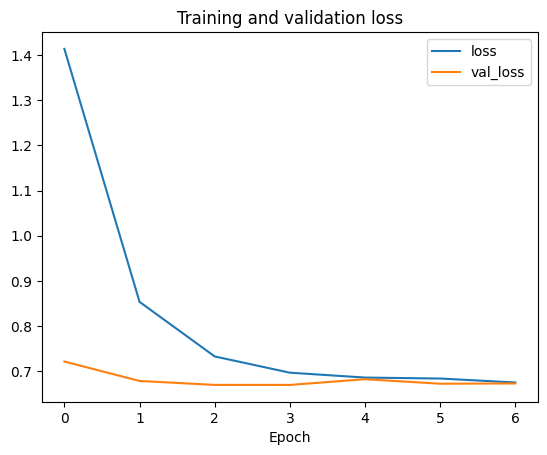

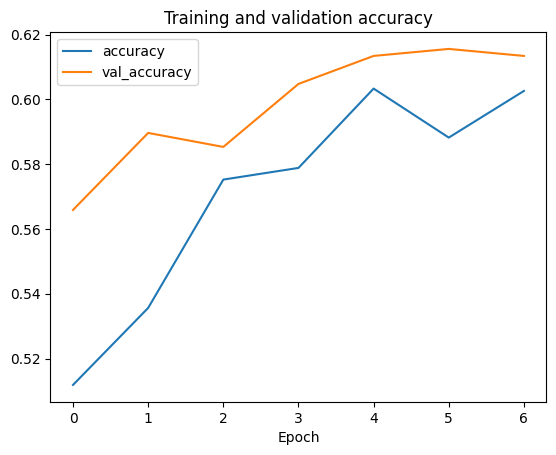

In [24]:

def plot_learning(history):
    tgts = ['loss', 'accuracy']
    vtgts = ['val_loss', 'val_accuracy']

    for tgt, val_tgt in zip(tgts, vtgts):
        plt.figure()
        plt.plot(history.history[tgt], label=tgt)
        plt.plot(history.history[val_tgt], label=val_tgt)
        plt.xlabel('Epoch')
        plt.legend()
        plt.title(f"Training and validation {tgt}")

# Assuming you have found the best model, its corresponding history is stored in best_history
plot_learning(best_history)

In [25]:
# After training, print the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [26]:
#best_model = create_model(0.001)
from sklearn.metrics import roc_curve, auc
# Get true labels of test data
test_pred1 = best_model.predict(test_generator)
test_true = test_generator.classes
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_true, test_pred1)
#roc_auc = auc(fpr, tpr)

# Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Threshold predictions based on optimal threshold
test_pred_binary1 = (test_pred1 > optimal_threshold).astype(int)

15/15 [==============================] - 6s 296ms/step


In [27]:
optimal_threshold

0.64984286

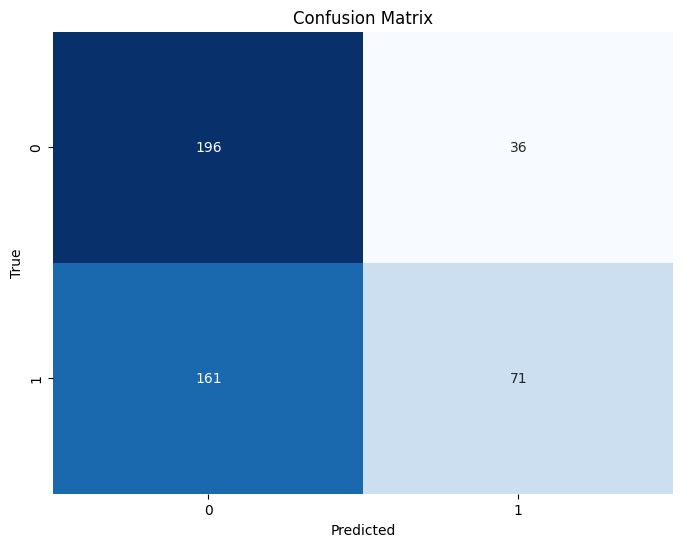

In [28]:
plot_confusion_matrix(test_true, test_pred_binary1)

In [29]:
from sklearn.metrics import classification_report# Generate classification report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [30]:
accuracy = accuracy_score(test_true, test_pred_binary1)
precision = precision_score(test_true, test_pred_binary1)
recall = recall_score(test_true, test_pred_binary1)
f1 = f1_score(test_true, test_pred_binary1)


print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.5754310344827587
Precision: 0.6635514018691588
Recall: 0.30603448275862066
F1 Score: 0.4188790560471976


In [31]:
import cv2
def visualize_data(image_data):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB (if necessary)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Identifying False Positives From Predictions

In [44]:

false_positives = []
for i in range(len(test_true)):
    if test_true[i] == 0 and test_pred_binary1[i] == 1:  # Actual negative, predicted positive
        false_positives.append(i)

# Select around 10 cases for closer examination
selected_false_positives = false_positives[:min(2, len(false_positives))]

selected_false_positives

[1, 13]

In [36]:
# Optionally, visualize the selected cases
#for idx in selected_false_positives:
    #image_path = test_generator.filenames[idx]  # Get the image path from the generator
    #visualize_data(image_path)
    #print("Predicted Probability:", test_pred1[idx])

## Identifying False Negtive Predictions

In [32]:
false_negatives = []
for i in range(len(test_true)):
    if test_true[i] == 1 and test_pred_binary1[i] == 0:  # Actual positive, predicted negative
        false_negatives.append(i)

# Select around 10 cases for closer examination
selected_false_negatives = false_negatives[:min(2, len(false_negatives))]

selected_false_negatives


[0, 2]

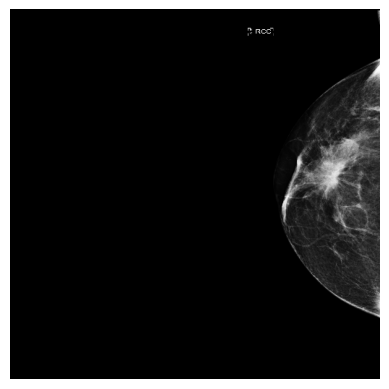

Predicted Probability: [0.49773756]


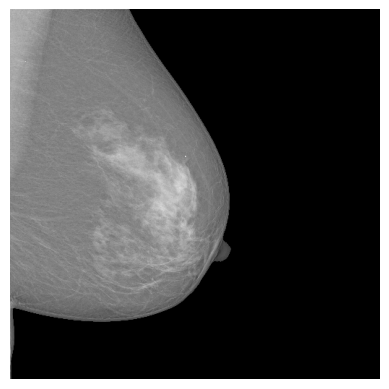

Predicted Probability: [0.45396498]


In [33]:

for idx in selected_false_negatives:
    image_path = test_generator.filenames[idx]  # Get the image path from the generator
    visualize_data(image_path)
    print("Predicted Probability:", test_pred1[idx])

In [38]:
selected_false_negatives

[]

# Model explanability

## LIME

In [39]:
#pip install lime

In [34]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 35ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


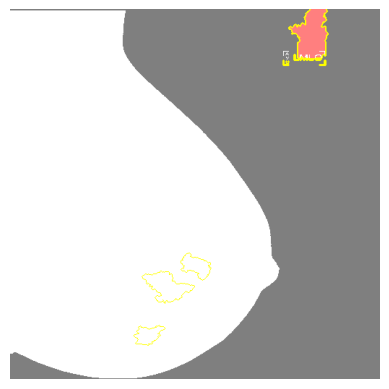

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


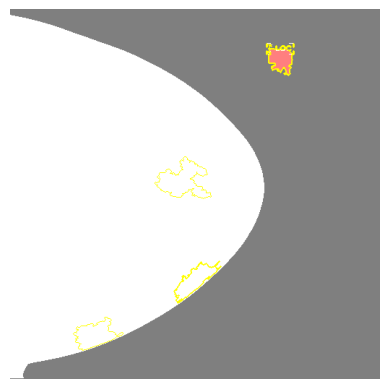

In [45]:
# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Define function to predict with your model
def predict_fn(images):
    # Preprocess images if necessary (resize, normalize, etc.)
    # Make predictions using your model
    predictions = best_model.predict(images)
    return predictions

# Iterate through false positive cases
for idx in selected_false_positives:
    image_path = test_generator.filepaths[idx]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Explain the prediction
    explanation = explainer.explain_instance(image, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

    # Get the image mask and show the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')
    plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


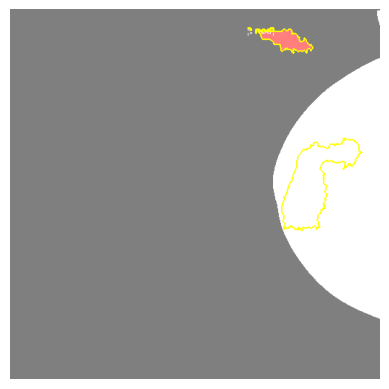

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


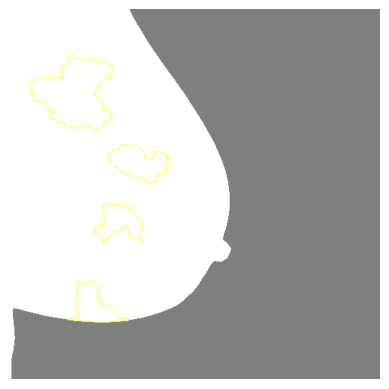

In [36]:
explainer = lime_image.LimeImageExplainer()

# Define function to predict with your model
def predict_fn(images):
    # Preprocess images if necessary (resize, normalize, etc.)
    # Make predictions using your model
    predictions = best_model.predict(images)
    return predictions

# Iterate through false positive cases
for idx in selected_false_negatives:
    image_path = test_generator.filepaths[idx]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Explain the prediction
    explanation = explainer.explain_instance(image, predict_fn, top_labels=1, hide_color=0, num_samples=1000)

    # Get the image mask and show the explanation
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.axis('off')
    plt.show()

## GradCam

In [37]:
from keras.models import Model
import tensorflow as tf

# Define function to get the last convolutional layer
def get_last_conv_layer(model):
    # Find the last convolutional layer in the model
    for layer in reversed(model.layers):
        if 'conv' in layer.name:
            return layer.name
    return None

In [38]:
last_conv_layer = get_last_conv_layer(best_model)
last_conv_layer

'conv2d_93'

In [39]:
# Create a new model that outputs the activations of the last convolutional layer
grad_model = Model(inputs=best_model.inputs, outputs=[best_model.get_layer(last_conv_layer).output, best_model.output])

In [40]:
# Step 3: Prepare the input image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (299, 299))  # Resize to 299x299 (InceptionV3 input size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values
    return img

In [41]:
# Step 4: Compute the gradients and activations
def compute_heatmap(image):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image)
        loss = predictions[:, tf.argmax(predictions[0])]

    # Get the gradients of the predicted class with respect to the activations of the last conv layer
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the heatmap
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    return heatmap.numpy()

In [42]:
# Step 5: Overlay heatmap on the original image
def overlay_heatmap(image, heatmap, alpha=0.5):
    # Resize heatmap to match the image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

    # Convert heatmap to RGB
    heatmap_rgb = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

    # Convert heatmap to float32
    heatmap_float = heatmap_rgb.astype(np.float32) / 255.0

    # Blend heatmap with the original image
    overlayed_img = cv2.addWeighted(heatmap_float, alpha, image, 1 - alpha, 0, dtype=cv2.CV_32F)

    # Convert overlayed image to uint8
    overlayed_img_uint8 = np.uint8(overlayed_img * 255)

    return overlayed_img_uint8

In [46]:
for idx in selected_false_positives:
    # Get the image path using the index
    image_path = test_generator.filepaths[idx]

    # Preprocess the image
    input_image = preprocess_image(image_path)

    # Compute the heatmap
    heatmap = compute_heatmap(input_image)

    # Overlay the heatmap on the original image
    overlayed_image = overlay_heatmap(input_image[0], heatmap[0])

    # Display the original image and the overlayed image
    plt.imshow(input_image[0])
    plt.axis('off')
    plt.show()

    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()

: 

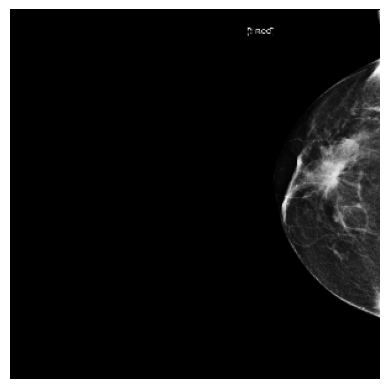

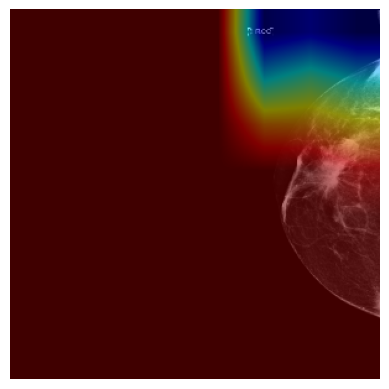

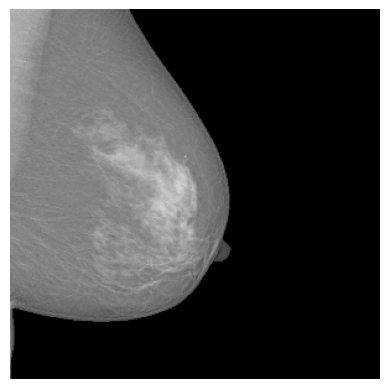

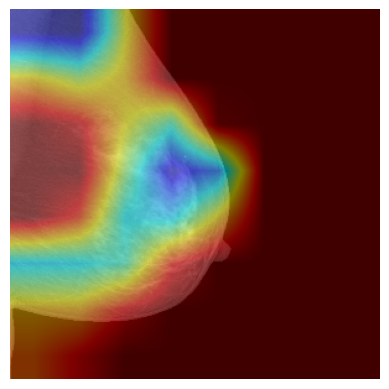

In [43]:
for idx in selected_false_negatives:
    # Get the image path using the index
    image_path = test_generator.filepaths[idx]

    # Preprocess the image
    input_image = preprocess_image(image_path)

    # Compute the heatmap
    heatmap = compute_heatmap(input_image)

    # Overlay the heatmap on the original image
    overlayed_image = overlay_heatmap(input_image[0], heatmap[0])

    # Display the original image and the overlayed image
    plt.imshow(input_image[0])
    plt.axis('off')
    plt.show()

    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()